# Import JAX

In [1]:
import jax
import haiku as hk
import optax
import numpy as np
import jax.numpy as jnp
from tqdm import tqdm
from dataclasses import dataclass
import graphviz

# we import some helper function/classes
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import Trainer, params_to_vec

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

/usr/local/lib/python3.8/dist-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


# Haiku can define NN as Pytorch does

In [2]:
class MLP(hk.Module):
  def __init__(self, width, depth):
    super().__init__()
    self.layers = []
    for i in range(depth):
      self.layers.append(hk.Linear(width))
      # we add ReLU activation to all layers except the last one.
      if i < depth-1:
        self.layers.append(jax.nn.relu)
    self.head = hk.Linear(1, name='head')
      
  def __call__(self, inputs):
    x = inputs
    for layer in self.layers:
      x = layer(x)
    x = self.head(x)
    return x

# This can be futher simplified as

In [3]:
@dataclass
class MLP_simple(hk.Module):
  width : int
  depth : int
      
  def __call__(self, inputs):
    x = inputs
    for i in range(self.depth):
      x = hk.Linear(self.width)(x)
      if i < self.depth-1:
        x = jax.nn.relu(x)
    x = hk.Linear(1, name='head')(x)
    return x

# In Haiku, Module can be decomposed to function and state by $\mathtt{hk.transform}$

In [4]:
# This function takes model (in hk.Module) and returns initializable models
WIDTH = 100
DEPTH = 3

# We define make_forward to generate forward function for multiple models
def make_forward(model):

  def _forward(inputs):
    return model(width=WIDTH, depth=DEPTH)(inputs)

  return hk.transform(_forward)

## The initializable model have method $\mathtt{init}$

In [5]:
# define pseudo random number generator for NN initialization
rng = jax.random.PRNGKey(42)
# define artificial input
batch = jnp.zeros((10, 1))

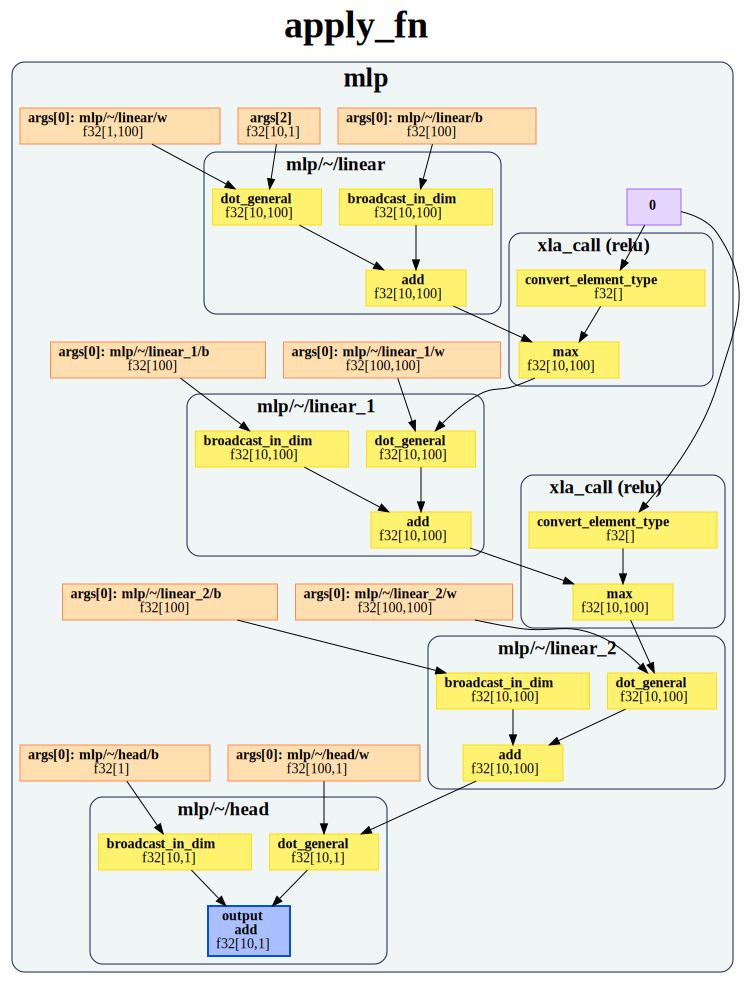

In [6]:
mlp = make_forward(MLP)
params_mlp = mlp.init(rng, batch)
dot = hk.experimental.to_dot(mlp.apply)(params_mlp, rng, batch)
graphviz.Source(dot)

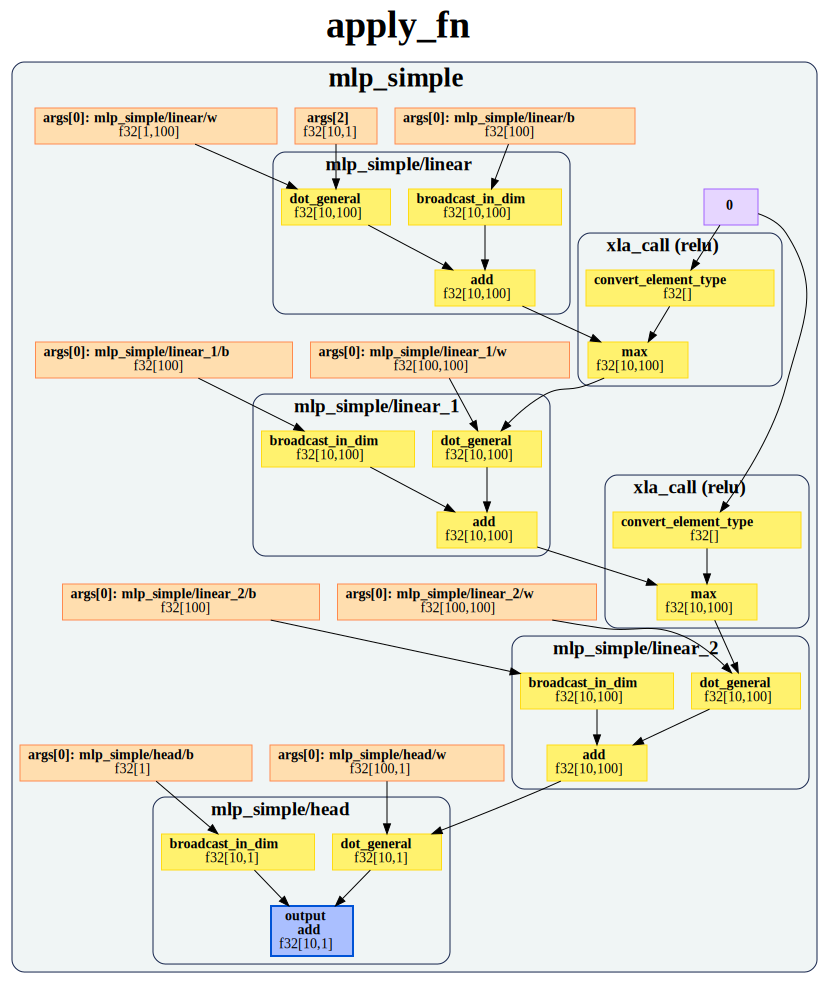

In [7]:
mlp_simple = make_forward(MLP_simple)
params_mlp_simple = mlp_simple.init(rng, batch)
dot = hk.experimental.to_dot(mlp_simple.apply)(params_mlp_simple, rng, batch)
graphviz.Source(dot)

In [8]:
print('First 5 values of head layer of MLP')
print(params_mlp['mlp/~/head']['w'][:5])
print('First 5 values of head layer of MLP_Simple')
print(params_mlp_simple['mlp_simple/head']['w'][:5])

First 5 values of head layer of MLP
[[ 0.00071125]
 [ 0.06380613]
 [-0.07427198]
 [ 0.19238584]
 [ 0.00050418]]
First 5 values of head layer of MLP_Simple
[[ 0.00071125]
 [ 0.06380613]
 [-0.07427198]
 [ 0.19238584]
 [ 0.00050418]]


## and another method to forward computation $\mathtt{apply}$

In [9]:
forward_mlp = mlp.apply
forward_mlp_simple = mlp_simple.apply

# Visualize the random initialized NNs!

In [10]:
x = jnp.linspace(-3, 3, 100).reshape(-1, 1)

pred_mlp = forward_mlp(params_mlp, rng, x)
pred_mlp_simple = forward_mlp_simple(params_mlp_simple, rng, x)
print(pred_mlp.shape)
print(pred_mlp_simple.shape)

(100, 1)
(100, 1)


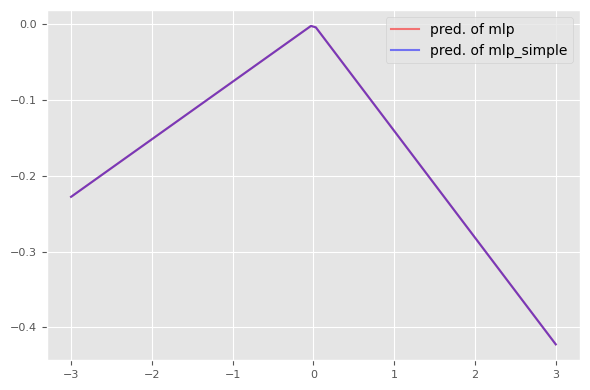

In [11]:
plt.plot(x.reshape(-1), pred_mlp.reshape(-1), label='pred. of mlp', color='red', alpha=0.5)
plt.plot(x.reshape(-1), pred_mlp_simple.reshape(-1), label='pred. of mlp_simple', color='blue', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Note that predictions of two NNs are identical!
This is due to the fixed rng key which is used for initialization of NN.

# If we use different PRNG for initialization,

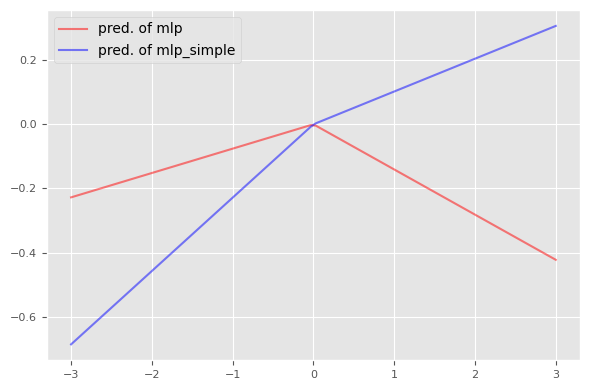

In [12]:
params_mlp = mlp.init(rng, batch)

_, rng_ = jax.random.split(rng, 2)
params_mlp_simple = mlp_simple.init(rng_, batch)
forward_mlp = mlp.apply
forward_mlp_simple = mlp_simple.apply

x = jnp.linspace(-3, 3, 100).reshape(-1, 1)

pred_mlp = forward_mlp(params_mlp, rng, x)
pred_mlp_simple = forward_mlp_simple(params_mlp_simple, rng, x)

plt.plot(x.reshape(-1), pred_mlp.reshape(-1), label='pred. of mlp', color='red', alpha=0.5)
plt.plot(x.reshape(-1), pred_mlp_simple.reshape(-1), label='pred. of mlp_simple', color='blue', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Initialize Trainer

In [13]:
tx = optax.sgd(learning_rate=0.01, momentum=0.9)

trainer_mlp = Trainer.create(
    apply_fn=forward_mlp,
    params=params_mlp,
    tx=tx,
)

trainer_mlp_simple = Trainer.create(
    apply_fn=forward_mlp_simple,
    params=params_mlp_simple,
    tx=tx,
)

# Define loss function

In [14]:
# define labels
f = lambda x : jnp.sin(x)
y = f(x)

In [15]:
def loss_fn(params, trainer, inputs, outputs, rng):

  pred = trainer.apply_fn(params, rng, inputs)
  loss = jnp.mean(jnp.sum(jnp.square(pred - outputs),axis=-1))
  weight_decay = jnp.sum(jnp.square(params_to_vec(params)))

  return loss + 5e-4 * weight_decay, (loss, weight_decay)

# Define Optimizer step

In [16]:
def opt_step(trainer, inputs, outputs, rng):

  grad_fn = jax.grad(loss_fn, has_aux=True)
  grads, (loss, wd) = grad_fn(
      trainer.params,
      trainer,
      inputs,
      outputs,
      rng,
  )

  grad_norm = jnp.sqrt(jnp.sum(jnp.square(params_to_vec(grads))))

  trainer = trainer.apply_gradients(grads=grads)

  log = {
      'loss': loss,
      'wd': wd,
      'grad_norm': grad_norm,
  }

  return log, trainer

# Train with data

In [17]:
opt_step_jitted = jax.jit(opt_step)

In [18]:
NUM_STEP = 1000

pbar = tqdm(range(NUM_STEP))
for step in pbar:

  rng, rng_ = jax.random.split(rng)
  log, trainer_mlp = opt_step_jitted(trainer_mlp, x, y, rng_)
  log, trainer_mlp_simple = opt_step_jitted(trainer_mlp_simple, x, y, rng_)

  pbar.set_postfix(log)

100%|██████████| 1000/1000 [00:02<00:00, 394.57it/s, grad_norm=0.013517821, loss=0.00018425821, wd=190.79639]


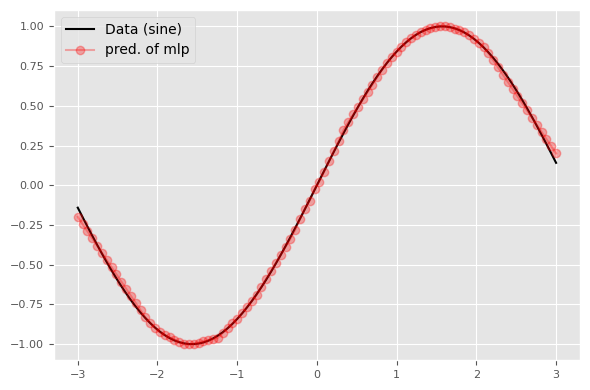

In [19]:
pred_mlp = trainer_mlp.apply_fn(trainer_mlp.params, rng, x)
pred_mlp_simple = trainer_mlp_simple.apply_fn(trainer_mlp_simple.params, rng, x)

plt.plot(x.reshape(-1), y.reshape(-1), label='Data (sine)', color='black')
plt.plot(x.reshape(-1), pred_mlp.reshape(-1), label='pred. of mlp', color='red', alpha=0.3, marker='o')
plt.legend()
plt.tight_layout()
plt.show()

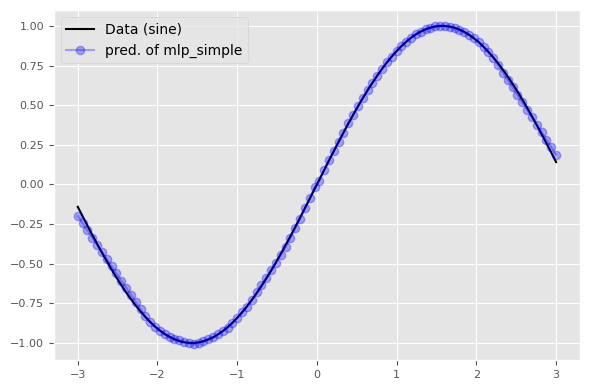

In [20]:
plt.plot(x.reshape(-1), y.reshape(-1), label='Data (sine)', color='black')
plt.plot(x.reshape(-1), pred_mlp_simple.reshape(-1), label='pred. of mlp_simple', color='blue', alpha=0.3, marker='o')
plt.legend()
plt.tight_layout()
plt.show()